Nama : Ahmad Sholihin

Email : asholeeqeen41@gmail.com

In [ ]:
!pip install -q keras

In [21]:
# Impor library yang di perlukan
import keras
import numpy as np
import pandas as pd
from keras.layers import Bidirectional
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf

In [22]:
data_train = pd.read_csv('openweatherdata-denpasar-2010-2020.csv')
data_train

,dt_iso,timezone,city_name,lat,lon,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,rain_6h,rain_12h,rain_24h,rain_today,snow_1h,snow_3h,snow_6h,snow_12h,snow_24h,snow_today,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1/1/2010 0:00,28800,Denpasar,-8.652497,115.219117,27.18,27.0,27.4,1007.9,87,3.1,310,NaN,NaN,NaN,NaN,6.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03d
1,1/1/2010 1:00,28800,Denpasar,-8.652497,115.219117,28.03,27.4,29.0,1008.1,83,3.1,280,NaN,NaN,NaN,NaN,6.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03d
2,1/1/2010 2:00,28800,Denpasar,-8.652497,115.219117,29.88,29.8,30.0,1008.1,74,4.6,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03d
3,1/1/2010 3:00,28800,Denpasar,-8.652497,115.219117,29.90,29.8,30.0,1008.1,79,3.6,260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03d
4,1/1/2010 4:00,28800,Denpasar,-8.652497,115.219117,30.27,29.8,31.0,1007.1,74,4.1,260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88711,1/7/2020 19:00,28800,Denpasar,-8.652497,115.219117,27.00,27.0,27.0,1007.0,94,4.1,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
88712,1/7/2020 20:00,28800,Denpasar,-8.652497,115.219117,27.00,27.0,27.0,1007.0,94,5.7,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
88713,1/7/2020 21:00,28800,Denpasar,-8.652497,115.219117,28.00,28.0,28.0,1007.0,83,6.7,290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
88714,1/7/2020 22:00,28800,Denpasar,-8.652497,115.219117,28.00,28.0,28.0,1007.0,83,6.2,290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03n


In [23]:
# Untuk menampilkan jumlah colomns dan data
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88716 entries, 0 to 88715
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt_iso               88716 non-null  object 
 1   timezone             88716 non-null  int64  
 2   city_name            88716 non-null  object 
 3   lat                  88716 non-null  float64
 4   lon                  88716 non-null  float64
 5   temp                 88716 non-null  float64
 6   temp_min             88716 non-null  float64
 7   temp_max             88716 non-null  float64
 8   pressure             88716 non-null  float64
 9   humidity             88716 non-null  int64  
 10  wind_speed           88716 non-null  float64
 11  wind_deg             88716 non-null  int64  
 12  rain_1h              913 non-null    float64
 13  rain_3h              8324 non-null   float64
 14  rain_6h              4079 non-null   float64
 15  rain_12h             3 non-null     

In [24]:
data_train.isnull().sum()

dt_iso                     0
timezone                   0
city_name                  0
lat                        0
lon                        0
temp                       0
temp_min                   0
temp_max                   0
pressure                   0
humidity                   0
wind_speed                 0
wind_deg                   0
rain_1h                87803
rain_3h                80392
rain_6h                84637
rain_12h               88713
rain_24h               85302
rain_today             88716
snow_1h                88716
snow_3h                88716
snow_6h                88716
snow_12h               88716
snow_24h               88716
snow_today             88716
clouds_all                 0
weather_id                 0
weather_main               0
weather_description        0
weather_icon               0
dtype: int64

In [25]:
date = data_train['dt_iso']
temperatur = data_train['temp']
print(temperatur.shape)
print(temperatur)

(88716,)
0        27.18
1        28.03
2        29.88
3        29.90
4        30.27
         ...  
88711    27.00
88712    27.00
88713    28.00
88714    28.00
88715    28.00
Name: temp, Length: 88716, dtype: float64


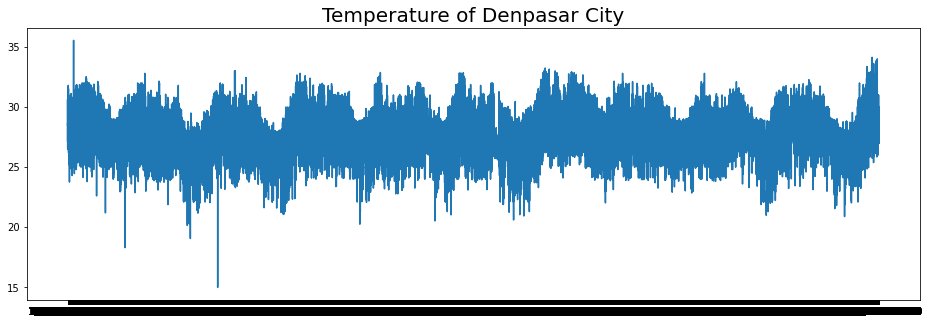

In [27]:
date = data_train['dt_iso'].values
temperatur = data_train['temp'].values

plt.figure(figsize=(16,5))
plt.plot(date, temperatur)
plt.title('Temperature of Denpasar City', fontsize=20);

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(temperatur, date, test_size = 0.2, random_state = 42)
print("X Train= ",len(X_train))
print("X Vaidation= ",len(X_validation))
print("Y train= ",len(y_train))
print("Y Validation= ",len(y_validation))

X Train=  70972
X Vaidation=  17744
Y train=  70972
Y Validation=  17744


In [29]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [30]:
tf.keras.backend.set_floatx('float64')
train_set = windowed_dataset(X_train, window_size=64, batch_size=64, shuffle_buffer=1000)
validation_set = windowed_dataset(X_validation, window_size=64, batch_size=64, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"), 
  tf.keras.layers.Dense(1),
])

In [33]:
temperatur = np.array(data_train['temp'])
Mae = (data_train['temp'].max() - data_train['temp'].min()) * 0.1
print(temperatur)
print("temperature terkecil\t= ", temperatur.min())
print("temperature terbesar\t= ", temperatur.max())
print("temperature rata-rata\t= ", temperatur.mean())
print("MAE\t\t\t= ",Mae)

[27.18 28.03 29.88 ... 28.   28.   28.  ]
temperature terkecil	=  15.0
temperature terbesar	=  35.54
temperature rata-rata	=  27.514082465395198
MAE			=  2.054


In [34]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,metrics=["mae"])

In [35]:
#Callback 10% mae
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<2.05 and logs.get('val_mae')<2.05):
      print("MAE < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [36]:
trainmodel = model.fit(train_set,epochs=100,
                       validation_data=validation_set,verbose=2,callbacks=[callbacks])

Epoch 1/100
1108/1108 - 230s - loss: 12.3514 - mae: 12.8208 - val_loss: 1.0775 - val_mae: 1.5161
Epoch 2/100
1108/1108 - 209s - loss: 1.0757 - mae: 1.5147 - val_loss: 1.0783 - val_mae: 1.5159
MAE < 10% skala data


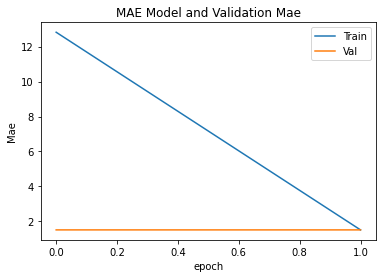

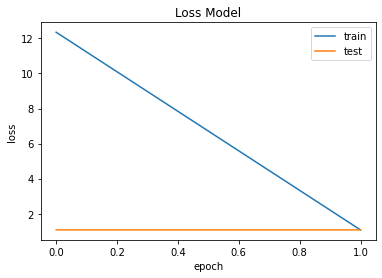

In [38]:
import matplotlib.pyplot as plt

# MAE
plt.plot(trainmodel.history['mae'])
plt.plot(trainmodel.history['val_mae'])
plt.title('MAE Model and Validation Mae')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()  

#Loss
plt.plot(trainmodel.history['loss'])
plt.plot(trainmodel.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()